## importing libs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## set up the movie data

In [3]:
df=pd.read_csv(r"mymoviedb.csv",engine="python")
df.head(5)

,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [4]:
df.shape

(9827, 9)

## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9827 entries, 0 to 9826
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Release_Date       9827 non-null   object 
 1   Title              9827 non-null   object 
 2   Overview           9827 non-null   object 
 3   Popularity         9827 non-null   float64
 4   Vote_Count         9827 non-null   int64  
 5   Vote_Average       9827 non-null   float64
 6   Original_Language  9827 non-null   object 
 7   Genre              9827 non-null   object 
 8   Poster_Url         9827 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 691.1+ KB


In [6]:
df.isnull().sum()

Release_Date         0
Title                0
Overview             0
Popularity           0
Vote_Count           0
Vote_Average         0
Original_Language    0
Genre                0
Poster_Url           0
dtype: int64

We kinda don't need all these columns to start our recommendation system, so i will choose only `genres` and `overview` columns

In [7]:
df =df[["Release_Date","Genre","Overview","Title"]]
df

,Release_Date,Genre,Overview,Title
0,2021-12-15,"Action, Adventure, Science Fiction",Peter Parker is unmasked and no longer able to...,Spider-Man: No Way Home
1,2022-03-01,"Crime, Mystery, Thriller","In his second year of fighting crime, Batman u...",The Batman
2,2022-02-25,Thriller,Stranded at a rest stop in the mountains durin...,No Exit
3,2021-11-24,"Animation, Comedy, Family, Fantasy","The tale of an extraordinary family, the Madri...",Encanto
4,2021-12-22,"Action, Adventure, Thriller, War",As a collection of history's worst tyrants and...,The King's Man
...,...,...,...,...
9822,1973-10-15,"Drama, Crime",A dramatization of the Starkweather-Fugate kil...,Badlands
9823,2020-10-01,Horror,A female vampire falls in love with a man she ...,Violent Delights
9824,2016-05-06,"Mystery, Thriller, Horror",When young and successful reporter Jamie finds...,The Offering
9825,2021-03-31,"Music, Drama, History",Billie Holiday spent much of her career being ...,The United States vs. Billie Holiday


In [8]:
df.isnull().sum()

Release_Date    0
Genre           0
Overview        0
Title           0
dtype: int64

Removing nulls

In [9]:
df=df.dropna()
df.isnull().sum()

Release_Date    0
Genre           0
Overview        0
Title           0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9827 entries, 0 to 9826
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Release_Date  9827 non-null   object
 1   Genre         9827 non-null   object
 2   Overview      9827 non-null   object
 3   Title         9827 non-null   object
dtypes: object(4)
memory usage: 307.2+ KB


## Combining

In [11]:
df.loc[:, "Combined"] =df["Genre"]+" "+df["Overview"]+" "+df["Title"]
df

,Release_Date,Genre,Overview,Title,Combined
0,2021-12-15,"Action, Adventure, Science Fiction",Peter Parker is unmasked and no longer able to...,Spider-Man: No Way Home,"Action, Adventure, Science Fiction Peter Parke..."
1,2022-03-01,"Crime, Mystery, Thriller","In his second year of fighting crime, Batman u...",The Batman,"Crime, Mystery, Thriller In his second year of..."
2,2022-02-25,Thriller,Stranded at a rest stop in the mountains durin...,No Exit,Thriller Stranded at a rest stop in the mounta...
3,2021-11-24,"Animation, Comedy, Family, Fantasy","The tale of an extraordinary family, the Madri...",Encanto,"Animation, Comedy, Family, Fantasy The tale of..."
4,2021-12-22,"Action, Adventure, Thriller, War",As a collection of history's worst tyrants and...,The King's Man,"Action, Adventure, Thriller, War As a collecti..."
...,...,...,...,...,...
9822,1973-10-15,"Drama, Crime",A dramatization of the Starkweather-Fugate kil...,Badlands,"Drama, Crime A dramatization of the Starkweath..."
9823,2020-10-01,Horror,A female vampire falls in love with a man she ...,Violent Delights,Horror A female vampire falls in love with a m...
9824,2016-05-06,"Mystery, Thriller, Horror",When young and successful reporter Jamie finds...,The Offering,"Mystery, Thriller, Horror When young and succe..."
9825,2021-03-31,"Music, Drama, History",Billie Holiday spent much of her career being ...,The United States vs. Billie Holiday,"Music, Drama, History Billie Holiday spent muc..."


Now we don't need the `Genre` and `Overview` columns as we've just combined them

In [12]:
df=df[["Title","Combined","Release_Date"]]
df

,Title,Combined,Release_Date
0,Spider-Man: No Way Home,"Action, Adventure, Science Fiction Peter Parke...",2021-12-15
1,The Batman,"Crime, Mystery, Thriller In his second year of...",2022-03-01
2,No Exit,Thriller Stranded at a rest stop in the mounta...,2022-02-25
3,Encanto,"Animation, Comedy, Family, Fantasy The tale of...",2021-11-24
4,The King's Man,"Action, Adventure, Thriller, War As a collecti...",2021-12-22
...,...,...,...
9822,Badlands,"Drama, Crime A dramatization of the Starkweath...",1973-10-15
9823,Violent Delights,Horror A female vampire falls in love with a m...,2020-10-01
9824,The Offering,"Mystery, Thriller, Horror When young and succe...",2016-05-06
9825,The United States vs. Billie Holiday,"Music, Drama, History Billie Holiday spent muc...",2021-03-31


i can see some commas in the `Combined` column so i will remove them

In [13]:
df.loc[:,"Combined"]=df["Combined"].str.replace(',','')
df

,Title,Combined,Release_Date
0,Spider-Man: No Way Home,Action Adventure Science Fiction Peter Parker ...,2021-12-15
1,The Batman,Crime Mystery Thriller In his second year of f...,2022-03-01
2,No Exit,Thriller Stranded at a rest stop in the mounta...,2022-02-25
3,Encanto,Animation Comedy Family Fantasy The tale of an...,2021-11-24
4,The King's Man,Action Adventure Thriller War As a collection ...,2021-12-22
...,...,...,...
9822,Badlands,Drama Crime A dramatization of the Starkweathe...,1973-10-15
9823,Violent Delights,Horror A female vampire falls in love with a m...,2020-10-01
9824,The Offering,Mystery Thriller Horror When young and success...,2016-05-06
9825,The United States vs. Billie Holiday,Music Drama History Billie Holiday spent much ...,2021-03-31


# WordCloud

## A word cloud is a visualization technique where the size of each word corresponds to how frequently it appears in the data

In [14]:
combined_text = " ".join(df["Combined"])
# generate(combined_text) --> this funciton counts every word, removes boring "stop words" (like "the", "and", "is"), and calculates the size each word should be based on its frequency
wordcloud=WordCloud(width=800,height=400,background_color="white").generate(combined_text)

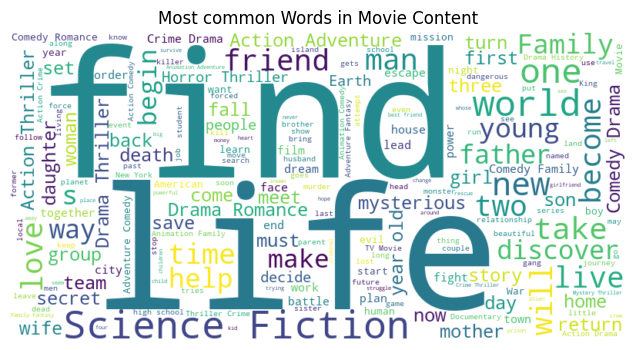

In [15]:
plt.figure(figsize=(10,4))
# "bilinear" --> is just a setting to make the letters look smoother and less pixelated.
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Most common Words in Movie Content")
plt.show()

i will add some words to the STOPWORD list to make the data more accurate

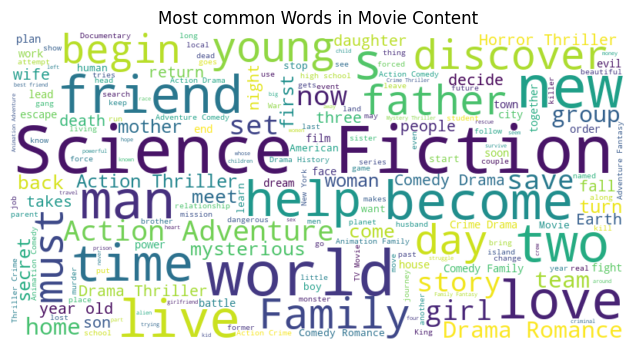

In [16]:
from wordcloud import STOPWORDS

my_stopwords =set(STOPWORDS)

my_stopwords.add("find")
my_stopwords.add("finds")
my_stopwords.add("one")
my_stopwords.add("way")
my_stopwords.add("will")
my_stopwords.add("take")
my_stopwords.add("make")
my_stopwords.add("life")

wordcloud=WordCloud(width=800,height=400,background_color="white",stopwords=my_stopwords).generate(combined_text)

#plotting again
plt.figure(figsize=(10,4))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Most common Words in Movie Content")
plt.show()

# nltk

In [17]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to C:\Users\Hp
[nltk_data]     845\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Hp
[nltk_data]     845\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Hp
[nltk_data]     845\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stop_words=set(stopwords.words("english"))

In [19]:
def fixing_text(text):
    # here i will remove any speacial character or any number
    text=re.sub(r"^a-zA-Z\s","",text)
    text=text.lower()
    tokens=word_tokenize(text)
    tokens=[word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [20]:
df.loc[:,"Cleaned_Combined"]=df["Combined"].apply(fixing_text)
df.head()

C:\Users\Hp 845\AppData\Local\Temp\ipykernel_25832\614236723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"Cleaned_Combined"]=df["Combined"].apply(fixing_text)


,Title,Combined,Release_Date,Cleaned_Combined
0,Spider-Man: No Way Home,Action Adventure Science Fiction Peter Parker ...,2021-12-15,action adventure science fiction peter parker ...
1,The Batman,Crime Mystery Thriller In his second year of f...,2022-03-01,crime mystery thriller second year fighting cr...
2,No Exit,Thriller Stranded at a rest stop in the mounta...,2022-02-25,thriller stranded rest stop mountains blizzard...
3,Encanto,Animation Comedy Family Fantasy The tale of an...,2021-11-24,animation comedy family fantasy tale extraordi...
4,The King's Man,Action Adventure Thriller War As a collection ...,2021-12-22,action adventure thriller war collection histo...


# TF-IDF (`Term Frequency-Inverse Document Frequency`)

In [21]:
# min_df --> ignore words that apears in fewer than 3 movies (as they maybe not that important or could also be a typo)
# max_df --> ignore words that appears in more than 90% of the movies (as they considered as a useless common words)
# max_features --> just remember the top 5000 important words
tf_idf=TfidfVectorizer(min_df=3,max_df=0.9,max_features=5000)

tf_idf_matrix=tf_idf.fit_transform(df["Cleaned_Combined"]) 

# Cosine Similarity

In [22]:
cosineSimilarity=cosine_similarity(tf_idf_matrix,tf_idf_matrix)
cosineSimilarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.02411526,
        0.02077573],
       [0.        , 1.        , 0.00940172, ..., 0.02226769, 0.        ,
        0.02693194],
       [0.        , 0.00940172, 1.        , ..., 0.02881783, 0.02396419,
        0.        ],
       ...,
       [0.        , 0.02226769, 0.02881783, ..., 1.        , 0.        ,
        0.        ],
       [0.02411526, 0.        , 0.02396419, ..., 0.        , 1.        ,
        0.03770587],
       [0.02077573, 0.02693194, 0.        , ..., 0.        , 0.03770587,
        1.        ]], shape=(9827, 9827))

In [23]:
def normalize(text):
    return re.sub(r'[^a-z0-9]', '', text.lower())

def similarity_score(a, b):
    # Score = number of matching character sequences.
    score = 0
    for i in range(len(a)):
        for j in range(i+1, len(a)+1):
            sub = a[i:j]
            if re.search(sub, b):
                score += len(sub)  # longer matched substring = more score
    return score

def possible_titles(movie_name,data=df):
    
    norm_name = normalize(movie_name)
    scores = []
    for title, release_date in zip(data["Title"], data["Release_Date"]):
        norm_title = normalize(title)
        if not norm_title: 
            continue

        score = similarity_score(norm_name, norm_title)
        # jsut ignoring any short titles
        if score < len(norm_name) * 0.4:
            continue

        scores.append((title, score, release_date))
    # sort highest similarity first based on the score then short length of the title
    scores.sort(key=lambda x: (x[1],-len(x[0])), reverse=True)

    top_matches = scores[:10]
    for i, (title, score, date) in enumerate(top_matches, 1):
        print(f"{i}: {title} ({date})")
    
    try:
        selection = input("Enter the index of the correct movie name (or 0 if none): ")
        num = int(selection)
        if 1 <= num <= len(top_matches):
            return top_matches[num-1][0] 
        else:
            return None
    except ValueError:
        return None

In [24]:
def recommendation_funtion(movie_name,cosineSimilarity=cosineSimilarity,data=df,top_n=5):
    idx=data[data["Title"].str.lower()==movie_name.lower()].index
    idx=idx[0]
    scores=list(enumerate(cosineSimilarity[idx])) # the `enumerate` for making a pair with the movie id and its score instead of just the score
    scores=sorted(scores,key=lambda x:x[1],reverse=True) # the lambda x:x[1] sort based on the second item in the pair (the Score), not the first item (the ID)
    scores=scores[1:top_n+1] # as the first index would surely be the same movie so we have to ignore it
    print(f"Top {top_n} recommendations for movie '{movie_name}' are:")
    movie_idxs=[i[0] for i in scores]
    return data[['Title']].iloc[movie_idxs]

In [25]:
movie_name=input("Enter your favorite movie name: ")
movie_name=possible_titles(movie_name,df)
recommendation_funtion(movie_name)

1: Spider-Man (2002-05-01)
2: Spider-Man (1977-09-14)
3: Spider-Man 3 (2007-05-01)
4: Spider-Man 2 (2004-06-25)
5: Italian Spiderman (2007-11-08)
6: Along Came a Spider (2001-04-06)
7: The Amazing Spider-Man (2012-06-23)
8: Spider-Man: Homecoming (2017-07-05)
9: Jack Black: Spider-Man (2002-06-06)
10: Spider-Man: No Way Home (2021-12-15)
Top 5 recommendations for movie 'Spider-Man' are:


,Title
191,Spider-Man: Into the Spider-Verse
201,Spider-Man 3
917,Spider-Man: Across the Spider-Verse (Part One)
1490,Spider-Man
2642,Spider-Man 2: Making the Amazing


In [26]:
# --- Export artifacts for the server ---
import json
import numpy as np
import pickle
import os

# Replace these names with the variables in your notebook if different:
# - tf_idf is your TfidfVectorizer object
# - tf_idf_matrix is the matrix returned by tf_idf.fit_transform(...)
# - cosineSimilarity is the NxN similarity matrix computed earlier
# - df is your dataframe that contains Title and Cleaned_Combined columns

# Make output dir (put the outputs where your server will read them)
out_dir = "server_artifacts"
os.makedirs(out_dir, exist_ok=True)

# 1) Save titles
titles = df["Title"].tolist()
with open(f"{out_dir}/titles.json", "w", encoding="utf-8") as f:
    json.dump(titles, f, ensure_ascii=False)

# 2) Save cleaned combined (optional but useful for debugging)
cleaned = df["Cleaned_Combined"].tolist()
with open(f"{out_dir}/cleaned.json", "w", encoding="utf-8") as f:
    json.dump(cleaned, f, ensure_ascii=False)

# 3) Save TF-IDF vocabulary (convert numpy types -> Python types)
vocab = tf_idf.vocabulary_

# Convert all keys and values into JSON-safe Python ints/strings
vocab_safe = {str(k): int(v) for k, v in vocab.items()}

with open(f"{out_dir}/vocab.json", "w", encoding="utf-8") as f:
    json.dump(vocab_safe, f, ensure_ascii=False)


# 4) Save TF-IDF matrix as dense numpy array (if large, consider sparse save)
# If the matrix is large and memory is a concern, you can save sparse with scipy.sparse.save_npz
try:
    from scipy import sparse
    sparse.save_npz(f"{out_dir}/tfidf_matrix.npz", tf_idf_matrix)
except Exception:
    np.save(f"{out_dir}/tfidf_matrix.npy", tf_idf_matrix.toarray())

# 5) Save the similarity matrix (cosineSimilarity computed in notebook)
# If you computed cosineSimilarity = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
np.save(f"{out_dir}/similarity.npy", cosineSimilarity)

# 6) If you had helper functions or model metadata, pickle them (optional)
with open(f"{out_dir}/metadata.pkl", "wb") as f:
    pickle.dump({"num_movies": len(titles)}, f)

print("Exported artifacts to:", out_dir)


Exported artifacts to: server_artifacts
